In [1]:
%load_ext autoreload
%autoreload 2

In [26]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from mixedbridge.stochastic_processes.examples import BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, MixedGuidedBridgeProcess
from mixedbridge.solvers.sde import WienerProcess, Euler, ModifiedEuler
from mixedbridge.utils.plotting import plot_sample_path

In [3]:
dim = 1
T = 1.0
dt = 1. / 500
dtype = jnp.float32

gamma = 2.0
sigma = 1.0

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)

In [103]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc        = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc           = BrownianProcess(gamma=gamma, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc           = BrownianAuxProcess(gamma=0.0, sigma=sigma, T=T, dim=dim, dtype=dtype)
true_bridge_proc   = BrownianBridgeProcess(gamma=gamma, sigma=sigma, score_fn=None, v=v, dtype=dtype, T=T)

guided_bridge_proc = GuidedBridgeProcess(ori_proc=ori_proc, 
                                         aux_proc=aux_proc, 
                                         x0=x0,
                                         v=v,
                                         L0=jnp.eye(dim, dtype=dtype), 
                                         Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
                                         ts=wiener_proc.ts,
                                         ode_solver_kernel=ode_solver_kernel)

aux_solver           = Euler(sde=aux_proc, wiener=wiener_proc)
true_bridge_solver   = Euler(sde=true_bridge_proc, wiener=wiener_proc)
guided_bridge_solver = Euler(sde=guided_bridge_proc, wiener=wiener_proc)

### Ito integral estimation

In [92]:
import numpy as np

# Parameters
T = 1.0          # Total time
N = 1000         # Number of time steps
dt = T / N       # Time step size
sigma = 0.5      # Constant in the SDE
gamma = 1.0      # Constant multiplier in f(X_t) = gamma * X_t
num_paths = 1000 # Number of Monte Carlo simulations

# Initialize storage for Monte Carlo simulations
ito_integrals = np.zeros(num_paths)

# Monte Carlo simulation loop
for i in range(num_paths):
    X_t = 0  # Initial condition X_0 = 0
    integral = 0  # To store the Itô integral for each path
    
    # Simulate the path and calculate the Itô integral
    for t in range(1, N+1):
        dW = np.sqrt(dt) * np.random.normal()  # Wiener increment
        f_X_t = gamma * X_t                    # Evaluate f(X_t)
        integral += f_X_t * dW                 # Approximate integral
        X_t += sigma * dW                      # Update X_t using SDE
    
    # Store the result for this path
    ito_integrals[i] = integral

# Calculate the expectation
expectation = np.mean(ito_integrals)
print("Estimated Expectation of the Itô Integral:", expectation)

Estimated Expectation of the Itô Integral: 0.009338960562379576


In [110]:
batch_size = 1000
rng_key, _ = jax.random.split(rng_key)
aux_path = aux_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=batch_size)

xs, log_ll, dWs = aux_path.xs, aux_path.log_likelihood, aux_path.dWs

sto_integrand = jnp.einsum("...i, ...i -> ...", xs[:, :-1], dWs)
sto_int = jnp.sum(sto_integrand, axis=1)
print(jnp.mean(sto_int))

-0.022879701


### Gradient descent on a single parameter

In [5]:
from tqdm import tqdm
import optax

In [118]:
def neural_net(theta, ts, xs):
    return theta[0] * xs + theta[1] * ts + theta[2]

def compute_loss(theta, ts, xs, dWs, log_ll):
    nus = neural_net(theta, ts[:, :-1], xs[:, :-1])
    sto_int = jnp.einsum("...i, ...i -> ...", nus, dWs)
    sto_int = jnp.sum(sto_int, axis=1)
    ll = jnp.exp(log_ll)
    # ll = jnp.clip(ll, 1e-5, 10.0)
    # det_int = 0.5 * theta**2 * T
    det_int = 0.5 * jnp.sum(jnp.sum(jnp.square(nus), axis=-1), axis=1) * dt
    loss = ll * (-sto_int + det_int)
    return jnp.mean(loss)

grad_fn = jax.grad(compute_loss)
theta = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
learning_rate = 0.001
optimizer = optax.chain(
    optax.adam(learning_rate=learning_rate * jnp.array([1.0, 1.0, 1.0])),
    optax.ema(0.995)
)
# optimizer = optax.sgd(learning_rate=learning_rate)
opt_state = optimizer.init(theta)


@jax.jit
def update_theta(theta, opt_state, ts, xs, dWs, log_ll):
    loss_value = compute_loss(theta, ts, xs, dWs, log_ll)
    grads = grad_fn(theta, ts, xs, dWs, log_ll)
    updates, opt_state = optimizer.update(grads, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    return theta, opt_state, loss_value, grads

# @jax.jit  # JIT compile for faster execution
# def update_theta(theta, ts, xs, dWs, dlog_ll):
#     loss_value = compute_loss(theta, ts, xs, dWs, dlog_ll)
#     grads = grad_fn(theta, ts, xs, dWs, dlog_ll)
#     return theta - learning_rate * grads, loss_value, grads

n_steps = 20000
batch_size = 256

rng_key = jax.random.PRNGKey(42)

losses = []
grads = []
thetas = []
pbar = tqdm(range(n_steps))
for _ in pbar:
    path = guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=batch_size, enforce_end_point=v)
    ts, xs, dWs, log_ll = path.ts, path.xs, path.dWs, path.log_likelihood
    ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
    ts = jnp.expand_dims(ts, axis=-1)
    
    theta, opt_state, loss, grad = update_theta(theta, opt_state, ts, xs, dWs, log_ll)
    # theta, loss, grad = update_theta(theta, ts, xs, dWs, log_ll)
    losses.append(loss)
    grads.append(grad)
    thetas.append(theta)
    pbar.set_postfix({f"theta[0]": f"{theta[0]:.5f}", f"theta[1]": f"{theta[1]:.5f}", f"theta[2]": f"{theta[2]:.5f}", "loss": f"{loss:.5f}"})
    rng_key, _ = jax.random.split(rng_key)


100%|██████████| 20000/20000 [02:22<00:00, 139.97it/s, theta[0]=-0.09838, theta[1]=-0.15421, theta[2]=-1.90139, loss=-0.10172] 


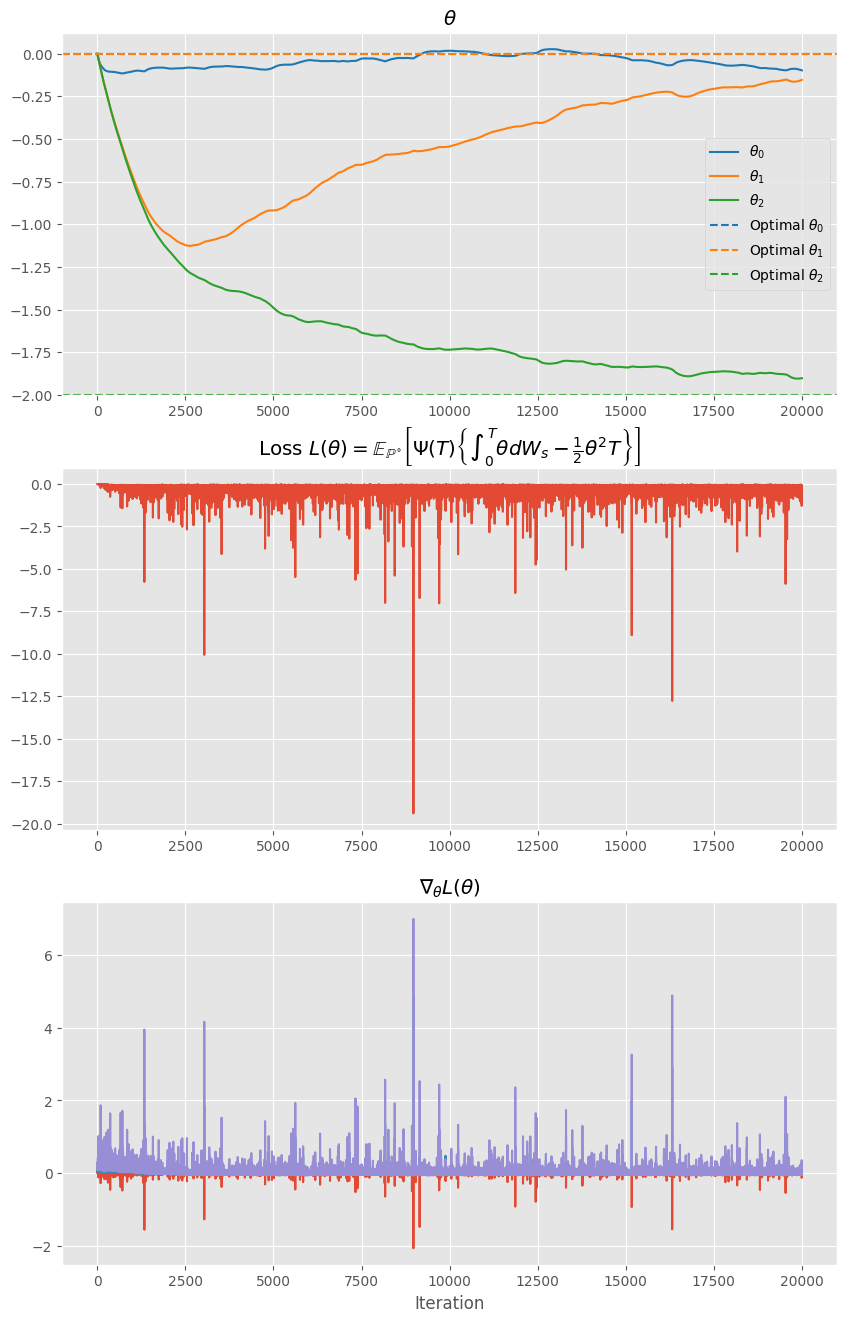

In [119]:
fig, axes = plt.subplots(3, 1, figsize=(10, 16))
thetas = jnp.array(thetas)
axes[0].plot(thetas[:, 0], label=r"$\theta_0$", color="tab:blue")
axes[0].plot(thetas[:, 1], label=r"$\theta_1$", color="tab:orange")
axes[0].plot(thetas[:, 2], label=r"$\theta_2$", color="tab:green")
axes[0].set_title(r"$\theta$")
axes[0].axhline(y=0.0, color='tab:blue', linestyle='--', label=r'Optimal $\theta_0$')
axes[0].axhline(y=0.0, color='tab:orange', linestyle='--', label=r'Optimal $\theta_1$')
axes[0].axhline(y=-(gamma/sigma), color='tab:green', linestyle='--', label=r'Optimal $\theta_2$')
axes[0].legend()

axes[1].plot(losses)
# axes[1].set_yscale("symlog")
axes[1].set_title(r"Loss $L(\theta)=\mathbb{E}_{\mathbb{P}^{\circ}}\left[\Psi(T)\left\{\int^T_0 \theta dW_s - \frac{1}{2}\theta^2 T\right\}\right]$")
axes[2].plot(grads)
# axes[2].set_yscale("symlog")
axes[2].set_title(r"$\nabla_\theta L(\theta)$")
axes[2].set_xlabel("Iteration")
plt.show()

In [120]:
def nu_learned(t, x):
    return thetas[-1][0] * x + thetas[-1][1] * t + thetas[-1][2]

mixed_bridge_proc = MixedGuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    x0=x0,
    v=v,
    nu=nu_learned,
    ts=wiener_proc.ts,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
)

In [121]:
mixed_bridge_solver = Euler(sde=mixed_bridge_proc, wiener=wiener_proc)
mixed_bridge_paths = mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=batch_size)

<Axes: title={'center': "PyTreeDef({'dWs': *, 'dts': *, 'log_likelihood': *, 'ts': *, 'xs': *})"}, xlabel='$t$', ylabel='$x$'>

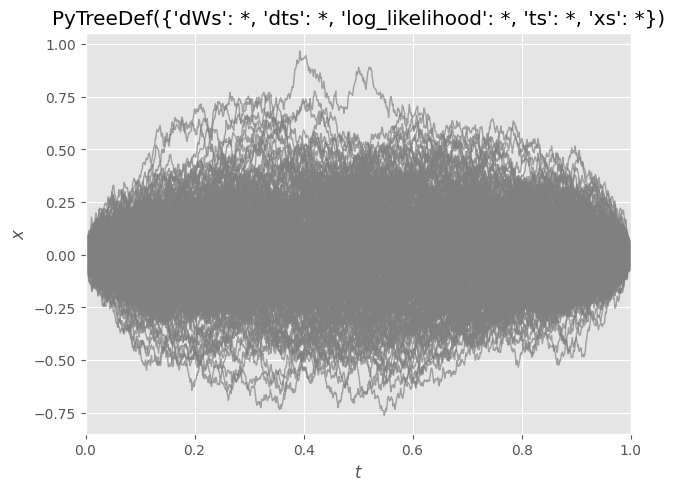

In [122]:
plot_sample_path(mixed_bridge_paths)